#### facebook/timesformer-base-finetuned-k400

In [1]:

from transformers import AutoImageProcessor, TimesformerForVideoClassification
import numpy as np
import torch

video = list(np.random.randn(8, 3, 224, 224))

processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")
model = TimesformerForVideoClassification.from_pretrained("facebook/timesformer-base-finetuned-k400")

inputs = processor(video, return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)
  logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

/home/vai/Desktop/chat_bot_experiment_one/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: The image to be converted to a PIL image contains values outside the range [0, 1], got [-4.612899711239714, 4.526782851217135] which cannot be converted to uint8.

In [2]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-5lcfarw4
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-5lcfarw4
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit ad410c9c0ae0d499aeec9a7af09b0636844b6274
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 KB 1.8 MB/s eta 0:00:00a 0:00:01
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.4.1-py3-none-any.whl size=29154 sha256=0ddca36d3ab7c326aa669577503c52cb129ae029cab17162867aeeda02cdaa08
  Stored in directory: /tmp/pip-ephem-wheel-cache-mgf0djbw/wheels/bf/c1/65/08857e57345ef1b34ba0edb4791f1b2594943e82f34e93a4ab
Successfully built chronos-forecasting


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
from chronos import ChronosPipeline

In [9]:
##https://finance.yahoo.com/quote/AAPL/history/
import pandas as pd

from datasets import load_dataset

ds = load_dataset("jettisonthenet/timeseries_trending_youtube_videos_2019-04-15_to_2020-04-15")

# apple_dataset = pd.read_csv("https://finance.yahoo.com/quote/AAPL/history/AAPL.csv")
print(ds)

# Display the first few rows of the 'train' dataset
print(ds['train'].to_pandas().head())

DatasetDict({
    train: Dataset({
        features: ['videostatsid', 'ytvideoid', 'views', 'comments', 'likes', 'dislikes', 'timestamp'],
        num_rows: 1541128
    })
})
   videostatsid    ytvideoid     views  comments   likes  dislikes  \
0             1  0GLbwkfhYZk   5722228     28229  185188     10860   
1             2  O4NB73HTlxI   3673770     31565  278477      4705   
2             3  VVRcXtSjPcE    253613      1025    4587        87   
3             4  adzYW5DZoWs  21567972     79208  478496     61703   
4             5  p_8yK2kmxoo   2385064     10703  133304      1323   

             timestamp  
0  2019-04-15 04:42:49  
1  2019-04-15 04:42:50  
2  2019-04-15 04:42:51  
3  2019-04-15 04:42:51  
4  2019-04-15 04:42:52  


In [11]:
test_size = 22
split_index = len(ds['train']) - test_size

# If the dataframe is shorter than 22 rows, all goes to test
if split_index < 0:
    train_views = pd.Series(dtype=float)
    test_views = ds['train']['views']
else:
    # Splitting the views column into training and test sets
    train_views = ds['train']['views'][:split_index]
    test_views = ds['train']['views'][split_index:]

In [ ]:
# Ensure the accelerate package is installed
%pip install accelerate

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  torch_dtype=torch.bfloat16,
)

In [16]:
context = torch.tensor(test_views)
prediction_length = test_size
forecast = pipeline.predict(context, prediction_length)

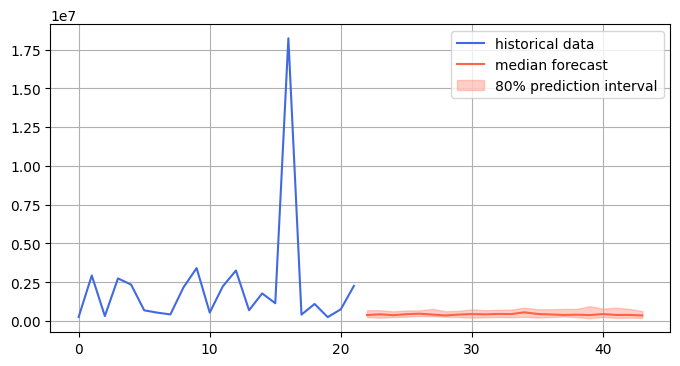

In [17]:
forecast_index = range(len(test_views), len(test_views) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(test_views, color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()